# Imports and Function Definitions

In [17]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set()

import warnings
warnings.filterwarnings('ignore')
# from polygon import RESTClient

import datetime as dt

In [ ]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi): return fi.plot('cols', 'feat_imp', 'barh', figsize=(15,20), legend=False)
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

In [ ]:
def model_selection(ml):
    print(ml)
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3,1e-5,1e-7]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=25)
        grid = dict()
        grid['max_depth'] = [3,5,7,10]
        grid['n_estimators'] = [10,50,100,1000]
        tscv = TimeSeriesSplit(n_splits=2)
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', cv = tscv)#, n_jobs=25), n_jobs=25)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
    
    
    print(model_best)
    y_pred = model_best.predict(X_test)
    print('MAE: ', mean_absolute_error(y_pred, y_test), '\nMSE: ', mean_squared_error(y_pred,y_test), '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_pred)#, [X_train, X_test, y_train, y_test])

# Cleaning and Merging

In [713]:
client = RESTClient(api_key="18U85gkK04AWHrbE3oWvG9b3fF8JdlxQ")

In [714]:
vxx = client.get_aggs(ticker='VXX', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
spy = client.get_aggs(ticker='SPY', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)
uso = client.get_aggs(ticker='USO', multiplier=5, timespan="minute", from_="2022-04-01", to="2022-09-01", limit=50000)

In [695]:
poly_dict = {'vxx':vxx, 'spy':spy, 'uso':uso}

In [696]:
for data in poly_dict.keys():
    poly_dict[data] = pd.DataFrame(poly_dict[data])[['close', 'timestamp']]
    poly_dict[data] = poly_dict[data].rename(columns={'close':'Close', 'timestamp':'Local time'})
    poly_dict[data]['Local time'] = pd.to_datetime(poly_dict[data]['Local time'], unit='ms')

In [697]:
vxx = poly_dict['vxx']
spy = poly_dict['spy']
uso = poly_dict['uso']

In [237]:
fut = pd.read_csv('LIGHT.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
gas = pd.read_csv('GAS.CMDUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
btc = pd.read_csv('BTCUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')
bond = pd.read_csv('USTBOND.TRUSD_Candlestick_5_M_BID_11.02.2020-11.02.2023.csv')

In [238]:
data_dict = {'fut':fut, 'gas':gas, #'vxx':vxx, 'spy':spy, #'uso':uso, 
            'btc':btc, 'bond':bond}

## Datetime and indexing

In [239]:
# idx = pd.to_datetime(data_dict['fut']['Local time'])
# idx=idx.apply(lambda x: x.replace(tzinfo=None))

In [240]:
for data in data_dict.keys():
    if data in ['vxx', 'spy', 'uso']:
        data_dict[data] = data_dict[data].set_index(idx)
        data_dict[data] = data_dict[data].drop(['Open', 'High', 'Low', 'Volume', 'Local time'], axis=1)
    else:     
        ix = pd.to_datetime(data_dict[data]["Local time"].apply(lambda x: " ".join(x.split()[0:2])), format='%d.%m.%Y %H:%M:%S.%f')
        data_dict[data] = data_dict[data].set_index(ix)['Close']

## Merging

In [241]:
# df = pd.DataFrame(index=data_dict['vxx'].index)
df = pd.DataFrame(index=data_dict['fut'].index)
for data in data_dict.keys():
    df = pd.merge(df, data_dict[data], left_index=True, right_index=True, suffixes=['', '_'+data], how='left')
df = df.rename(columns={'Close':'Close_fut'})

## Cut to market hours

In [242]:
df['date'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').date(), axis=1)
df['time'] = df.apply(lambda x: dt.datetime.strptime(str(x.name), '%Y-%m-%d %H:%M:%S').time(), axis=1)

In [243]:
df = df.loc[ (df['time']>dt.time(7)) & (df['time']<dt.time(16)) ]
df = df[df.index.dayofweek < 5]

The plot below shows the high daily variance and the gaps between data are non-trading hours

In [244]:
df

,Close_fut,Close_gas,Close_btc,Close_bond,date,time
Local time,,,,,,
2020-02-11 07:05:00,50.445,1.7640,9801,162.280,2020-02-11,07:05:00
2020-02-11 07:10:00,50.375,1.7674,9815,162.311,2020-02-11,07:10:00
2020-02-11 07:15:00,50.326,1.7703,9816,162.248,2020-02-11,07:15:00
2020-02-11 07:20:00,50.356,1.7725,9821,162.561,2020-02-11,07:20:00
2020-02-11 07:25:00,50.445,1.7734,9816,162.401,2020-02-11,07:25:00
...,...,...,...,...,...,...
2023-02-10 15:35:00,79.799,2.5718,21531,126.899,2023-02-10,15:35:00
2023-02-10 15:40:00,79.779,2.5721,21487,126.899,2023-02-10,15:40:00
2023-02-10 15:45:00,79.764,2.5739,21552,126.901,2023-02-10,15:45:00


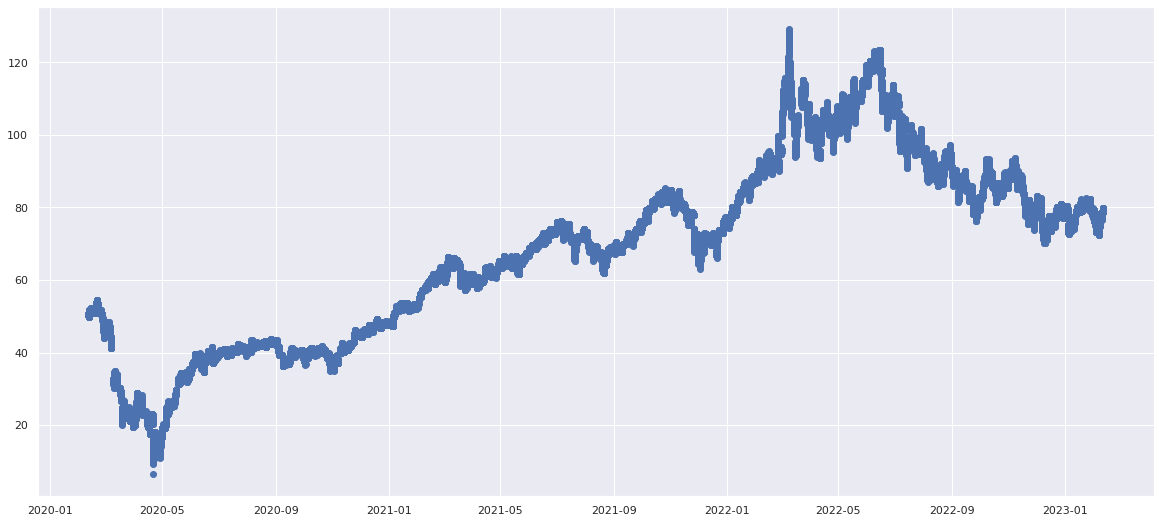

In [245]:
plt.subplots(figsize=(20,9))
plt.scatter(df.index, df['Close_fut'])

# Test Train Splits

## brainstorm:
2 train test splitting techniques: day by day or chunk by chunk.

- day by day: train p of the day test 1-p for each day, record accuracy for each day 
    - bad: small amount of data per train
    - good: consistent times predicted
- chunk by chunk: train n data points test m data points, record accuracy for each chunk
    - bad: inconsistent time predicted; different days have different vol levels and predicting across days could be problematic
    - good: more train data, could get different prediction horizons, no dependency on prediction time

## Day by Day

We split the data into individual days.  We calculate the $n$ period rolling standard deviation as our outcome measure within each day.  Then, we can concat the data together

In [246]:
days = list(set([d.date() for d in df.index]))

In [247]:
set(df.columns) - {'date', 'time'}

{'Close_bond', 'Close_btc', 'Close_fut', 'Close_gas'}

In [271]:
n=12
day_dict = {}
for day in days:
        
    day_dict[day] = df.loc[df['date'] == day]
    del day_dict[day]['date']
    
    for feat in set(df.columns) - {'date', 'time'}:
        day_dict[day][feat] = np.log( day_dict[day][feat] / day_dict[day][feat].shift(1) )#.shift(1) #last shift new
    
    day_dict[day][str(n)+'_oil_std'] = day_dict[day].rolling(n)['Close_fut'].std()
    day_dict[day] = day_dict[day][n:]

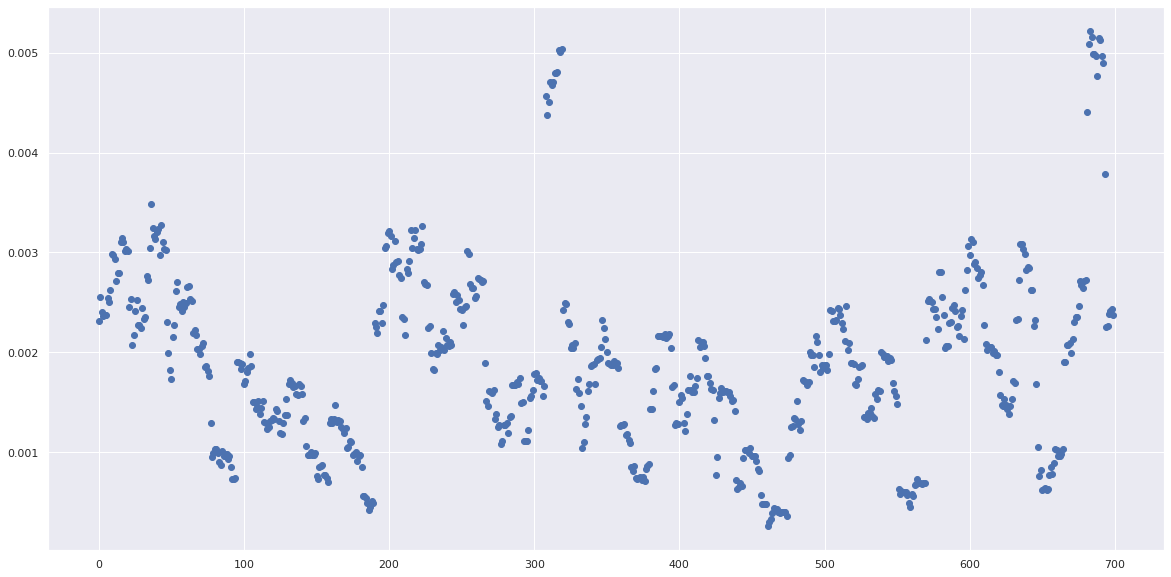

In [272]:
concat = pd.concat(day_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(700), concat[:700].reset_index(drop=True)[str(n)+'_oil_std'])

## Examining Temporal Structure

In [273]:
time_dist = concat.groupby('time')[str(n)+'_oil_std'].mean()

<AxesSubplot:xlabel='time'>

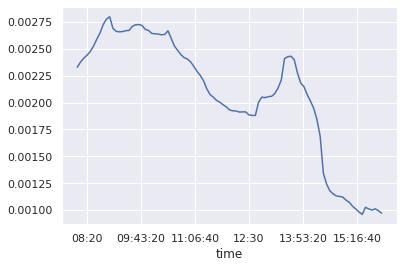

In [274]:
time_dist.plot()

The above plot shows that the trading volatility is clustered around the morning and roughly 2pm (historic oil desk close).  This is to be expected.  It will be important to strip times from the is dataset.

In [275]:
time_rets = concat.groupby('time')['Close_fut'].apply(lambda x: np.mean(abs(x)))

<AxesSubplot:xlabel='time'>

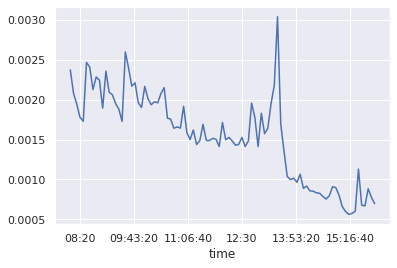

In [276]:
time_rets.plot()

Again we see the largest log returns concentrated around 1:30 pm

## Chunk by Chunk

In [277]:
len(days)

784

In [278]:
chunk_size = 1000

In [279]:
chunk_dict = {}

In [280]:
for i,chunk in df.groupby(np.arange(len(df)) // chunk_size):
    chunk_dict[i] = chunk.drop(['date', 'time'], axis=1)

In [281]:
chunk_indices = list(chunk_dict.keys())

In [282]:
len(chunk_indices)

84

In [70]:
from scipy import stats
from scipy.special import gamma
from math import ceil, sqrt

# Define the feature functions
# Some constants for feature creation
mu_1 = np.sqrt((2 / np.pi))
mu_43 = 2 ** (2 / 3) * gamma(7 / 6) * gamma(1 / 2) ** (-1)

# Since the data has not been resampled
M = 1

def rv(x):
    # Realized Variance (Andersen and Bollerslev, 1998)
    return (x ** 2).sum()

def rav(x):
    # Realized absolute variation (Forsberg and Ghysels, 2007)
    return mu_1 ** (-1) * M ** (-.5) * x.abs().sum()

def bv(x):
    # Realized bipower variation (Barndorff-Nielsen and Shephard; 2004, 2006)
    return mu_1 ** (-2) * (x.abs() * x.shift(1).abs()).sum()

def tq(x):
    # Standardized tri-power quarticity (see e.g. Forsberg & Ghysels, 2007)
    return M * mu_43 ** (-3) *(x.abs() ** (4 / 3) * x.shift(1).abs() ** (4 / 3) * 
                                x.shift(2).abs() ** (4 / 3)).sum()
    
def jump_test(x):
    # Jump test by Huang and Tauchen (2005)
    j = ((np.log(rv(x)+0.00000001) - np.log(bv(x)+0.00000001)) / \
        ((mu_1 ** -4 + 2 * mu_1 ** -2 - 5) / (M * tq(x) * bv(x) ** -2)) ** 0.5)

    jump = abs(j) >= stats.norm.ppf(0.999)
    
    return jump

def rv_m(x):
    # Realized Semivariance (Barndorff-Nielsen, Kinnebrock and Shephard, 2010)
    return((x ** 2 * (x < 0)).sum())

def rv_p(x):
    return((x ** 2 * (x > 0)).sum())

def sjv_p(x):
    # Signed jump variation (Patton and Sheppard, 2015)
    return((rv_p(x) - rv_m(x)) * (rv_p(x) - rv_m(x) > 0))

def sjv_m(x):
    # Signed jump variation (Patton and Sheppard, 2015)
    return((rv_p(x) - rv_m(x)) * (rv_p(x) - rv_m(x) < 0))

def rs(x):
    # Realized Skewness and Kurtosis  (see, e.g. Amaya, Christoffersen, Jacobs and Vasquez, 2015)
    return(np.sqrt(M) * (x ** 3).sum() / rv(x) ** (3 / 2))

def rk(x):
    return(M * (x ** 4).sum() / rv(x) ** 2)

In [283]:
%%time
n=12

for chunk in chunk_indices[:2]:    
    for feat in set(df.columns) - {'date', 'time'}:
        chunk_dict[chunk][feat] = np.log( chunk_dict[chunk][feat] / chunk_dict[chunk][feat].shift(1) )#.shift(1)
        
    chunk_dict[chunk][str(n)+'_oil_std'] = chunk_dict[chunk].rolling(n)['Close_fut'].std()
    
    feat_funcs = [rv,rav,bv,tq,jump_test,rv_m,rv_p,sjv_p,sjv_m,rs,rk]

    for func in feat_funcs:
        # print(func)
        chunk_dict[chunk]["Fut_close_"+func.__name__] = chunk_dict[chunk]['Close_fut'].rolling(n).apply(func)#.shift(1)
    
    chunk_dict[chunk] = chunk_dict[chunk][n:]

CPU times: user 19.2 s, sys: 38.8 ms, total: 19.2 s
Wall time: 19.2 s


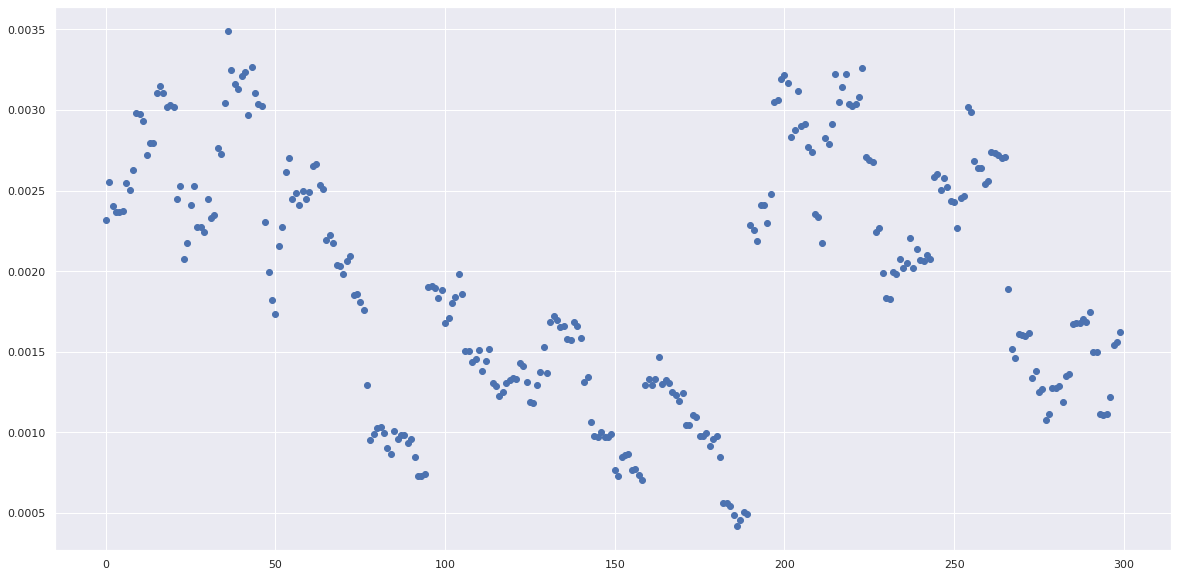

In [285]:
concat = pd.concat(day_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(300), concat[:300].reset_index(drop=True)[str(n)+'_oil_std'])

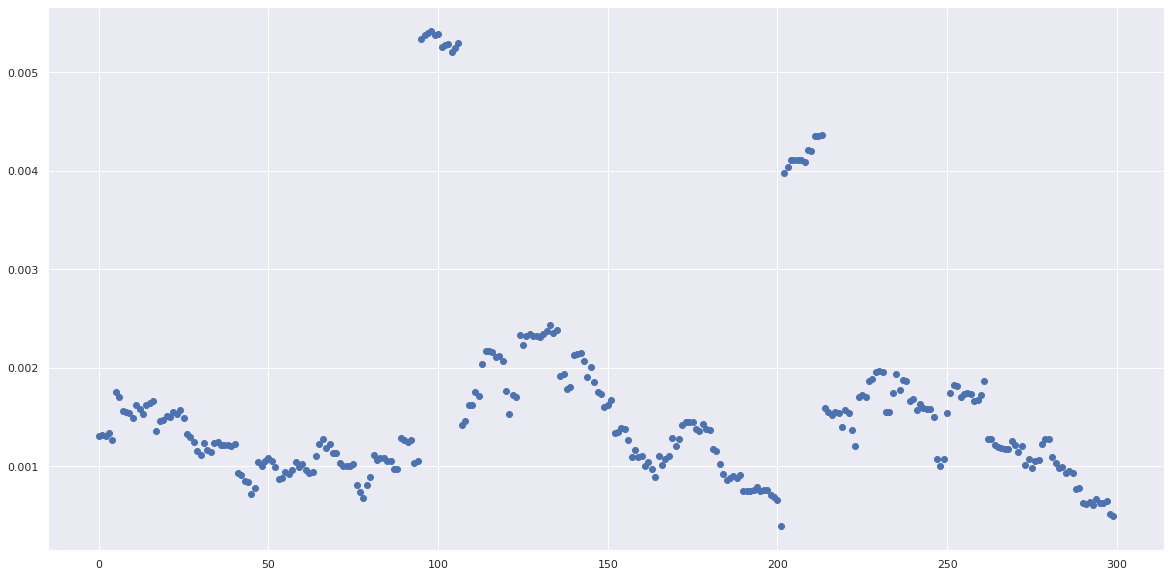

In [286]:
concat = pd.concat(chunk_dict.values())
plt.subplots(figsize=(20,10))
plt.scatter(range(300), concat[:300].reset_index(drop=True)[str(n)+'_oil_std'])

In [22]:
concat.to_csv('test_data.csv')

We can see the difference in splitting methods.  New days will appear as large jumps like this rather than smooth as in the day splitting.  

We might be able to fix this with some kind of smoothing technique ie windsorize and replace with some interpolation but it is probably best to just leave it be.  

# Predicting

We train on a fraction $p$ of each chunk and test on the remaining $1-p$ of the chunk.

In [288]:
df=pd.read_csv('test_data.csv')

In [289]:
df

,Local time,Close_fut,Close_gas,Close_btc,Close_bond,12_oil_std
0,2020-02-11 08:10:00,0.001783,0.000057,0.000610,-0.000191,0.001318
1,2020-02-11 08:15:00,0.001602,0.001810,0.000914,-0.000203,0.001308
2,2020-02-11 08:20:00,-0.000415,-0.000170,-0.000203,0.000424,0.001332
3,2020-02-11 08:25:00,0.000613,0.003836,-0.001016,0.000381,0.001264
4,2020-02-11 08:30:00,-0.003978,0.000675,-0.001730,0.000350,0.001754
...,...,...,...,...,...,...
82791,2023-02-10 15:35:00,0.000251,0.000000,-0.000696,-0.000252,0.000467
82792,2023-02-10 15:40:00,-0.000251,0.000117,-0.002046,0.000000,0.000418
82793,2023-02-10 15:45:00,-0.000188,0.000700,0.003021,0.000016,0.000419
82794,2023-02-10 15:50:00,-0.000313,-0.000700,-0.000696,0.000315,0.000422


We get a train test split for each chunk.

In [80]:
chunk_size = 1000
data_chunks = {}

for i,chunk in df.groupby(np.arange(len(df)) // chunk_size):
    total = chunk#.drop(['date', 'time'], axis=1)
    
    X = total[['Close_gas', 'Close_btc', 'Close_bond', 'Close_fut']]
    Y = total['12_oil_std']
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
    
    data_chunks[i] = [X_train, X_test, y_train, y_test]

In [81]:
len(data_chunks)

83

## Predicting by chunk

In [82]:
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.linear_model import ElasticNet, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, accuracy_score, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, KFold, StratifiedKFold
from sklearn_extensions.kernel_regression import KernelRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [444]:
# A bunch of nonparametric regression models + some parametric baselines
def model_selection(ml, data_list):
    X_train, X_test, y_train, y_test = data_list[0], data_list[1], data_list[2], data_list[3]
    # print(ml)
    
    cores=35
    
    model_best = ''
    if ml == 'GB':
        model = GradientBoostingRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-3, 2*1e-3, 3*1e-3, 4*1e-3, 5*1e-3, 7*1e-3] #
        grid['n_estimators'] = [1000,2000] 
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = GradientBoostingRegressor(learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                                              ).fit(X_train, y_train)

    elif ml == 'RF':
        model = RandomForestRegressor(n_jobs=cores)
        grid = dict()
        grid['max_depth'] = [3,4,5,7]
        grid['n_estimators'] = [1000,2000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = RandomForestRegressor(
                    max_depth=grid_result.best_params_['max_depth'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\

                        ).fit(X_train, y_train)
    elif ml == 'AB':
        model = AdaBoostRegressor()
        grid = dict()
        grid['learning_rate'] = [1e-4,1e-2,1]
        grid['n_estimators'] = [100,1000]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)

        model_best = AdaBoostRegressor(
                    learning_rate=grid_result.best_params_['learning_rate'],\
                    n_estimators=grid_result.best_params_['n_estimators'],\
                        ).fit(X_train, y_train)
          
    elif ml == 'KR':
        model = KernelRidge()
        grid = dict()
        grid['alpha'] = [1e-3,1e-2,1e-1]
        grid["kernel"] = ["poly", "cosine"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KernelRidge(alpha=grid_result.best_params_["alpha"],
                                 kernel=grid_result.best_params_["kernel"]).fit(X_train, y_train)
    elif ml == 'R':
        model = Ridge()
        grid = dict()
        grid['alpha'] = [1e-2,1e-3,1e-1]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = Ridge(alpha=grid_result.best_params_["alpha"]).fit(X_train, y_train)
        
    elif ml == "LA":
        model = Lasso()
        grid = dict()
        grid['alpha'] = [1e-6,1e-5, 1e-4, 1e-3]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = Lasso(alpha=grid_result.best_params_["alpha"]).fit(X_train, y_train)
        
        
    elif ml == "EN":
        model = ElasticNet()
        grid = dict()
        grid['alpha'] = [1e-6,1e-5, 1e-4, 1e-3]
        grid["l1_ratio"] = [0.1,0.5,0.7,0.9,0.95]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = ElasticNet(alpha=grid_result.best_params_["alpha"],
                                l1_ratio = grid_result.best_params_["l1_ratio"]).fit(X_train, y_train)
    
    elif ml == "NW":
        # Bandwidth is selected automatically
        model = KernelRegression()
        grid = dict()
        grid["gamma"] = [1e-2, 1e-1, 1, 10,100]
        grid['kernel'] = ["rbf","poly"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KernelRegression(gamma=grid_result.best_params_["gamma"],
                            kernel = grid_result.best_params_["kernel"]).fit(X_train, y_train)
        
    elif ml == "KN":
        model = KNeighborsRegressor()
        grid = dict()
        grid["n_neighbors"] = [5,10,40,100]
        grid['weights'] = ["uniform","distance"]
        grid_search = GridSearchCV(estimator=model, param_grid=grid, scoring='neg_mean_squared_error', n_jobs=cores)
        grid_result = grid_search.fit(X_train, y_train)
        model_best = KNeighborsRegressor(n_neighbors=grid_result.best_params_["n_neighbors"],
                            weights = grid_result.best_params_["weights"]).fit(X_train, y_train)
        
    # print(model_best)
    y_pred = model_best.predict(X_test)
    acc = {'MAE':mean_absolute_error(y_pred, y_test), 'MAPE':100 * mean_absolute_error(y_pred, y_test)/np.mean(y_test), 
           'MSE':mean_squared_error(y_pred,y_test), 'RMSE':np.sqrt(mean_squared_error(y_pred,y_test))}
    
    # print('MAE: ', mean_absolute_error(y_pred, y_test), 
    #       'MAE%: ', 100 * mean_absolute_error(y_pred, y_test)/np.mean(y_test), 
    #       '\nMSE: ', mean_squared_error(y_pred,y_test), 
    #       '\nRMSE: ', np.sqrt(mean_squared_error(y_pred,y_test)))

    return(model_best, y_test, y_pred, acc)

In [106]:
%%time
chunk_results = {}
indices = data_chunks.keys()

indices = list(indices)

mod_list = ['GB', 'RF', 'AB', 'KR', 'R', 'LA', 'EN', 'NW', 'KN']

for i in indices:
    t = dt.datetime.now()
    chunk_results[i] = {}
    for ml in mod_list:
        chunk_results[i][ml] = model_selection(ml, data_chunks[i])
    print(i, dt.datetime.now()-t)

0 0:00:21.928838
1 0:00:18.526302
2 0:00:21.332554
3 0:00:18.624204
4 0:00:26.157691
5 0:00:15.699685
6 0:00:18.215578
7 0:00:22.903170
8 0:00:20.562592
9 0:00:21.134479
10 0:00:20.925249
11 0:00:17.225143
12 0:00:15.430487
13 0:00:15.884101
14 0:00:21.191981
15 0:00:18.533857
16 0:00:18.116262
17 0:00:15.873829
18 0:00:18.627627
19 0:00:23.043267
20 0:00:21.415202
21 0:00:18.122051
22 0:00:15.387737
23 0:00:16.003321
24 0:00:19.022791
25 0:00:24.466780
26 0:00:17.158539
27 0:00:20.384312
28 0:00:20.117606
29 0:00:20.735002
30 0:00:22.192032
31 0:00:17.716973
32 0:00:23.438790
33 0:00:20.603035
34 0:00:15.481415
35 0:00:15.590423
36 0:00:19.893621
37 0:00:18.939029
38 0:00:17.861055
39 0:00:15.728581
40 0:00:24.404964
41 0:00:23.457765
42 0:00:23.219970
43 0:00:21.157231
44 0:00:14.119720
45 0:00:21.480059
46 0:00:17.840185
47 0:00:20.758689
48 0:00:22.369471
49 0:00:20.592920
50 0:00:23.653909
51 0:00:18.484810
52 0:00:23.625178
53 0:00:23.849089
54 0:00:18.729793
55 0:00:15.903829
56

In [107]:
for label in chunk_results.keys():
    chunk_results[label]

In [108]:
acc_dict = {}
for chunk in chunk_results.keys():
    for m in mod_list:
        acc_dict[str(chunk)+m] = chunk_results[chunk][m][-1]
        acc_dict[str(chunk)+m]['model'] = m
        # acc_dict[m].append(m)

In [109]:
acc_df = pd.DataFrame(acc_dict).transpose()

In [113]:
acc_df

,MAE,MAPE,MSE,RMSE,model
0GB,0.00155702,68.1247,1.06173e-05,0.00325843,GB
0RF,0.00159527,69.798,1.09087e-05,0.00330283,RF
0AB,0.00158904,69.5257,1.13249e-05,0.00336525,AB
0KR,0.00162457,71.08,1.20572e-05,0.00347235,KR
0R,0.00162563,71.1267,1.20537e-05,0.00347184,R
...,...,...,...,...,...
82R,0.000782065,72.4023,7.98161e-07,0.000893398,R
82LA,0.000782065,72.4023,7.98161e-07,0.000893399,LA
82EN,0.000782065,72.4023,7.98161e-07,0.000893399,EN
82NW,0.000781433,72.3437,7.96861e-07,0.000892671,NW


In [112]:
acc_df.reset_index(drop=True).groupby('model')['MAPE'].apply(lambda x: np.mean(x))

model
AB    48.891872
EN    53.630768
GB    49.292161
KN    46.353923
KR    53.783620
LA    53.630768
NW    53.408520
R     53.755003
RF    48.823544
Name: MAPE, dtype: float64

# WIth new features

In [290]:
df=pd.read_csv('combined_chunks.csv')

In [291]:
df = df.fillna(method='ffill')

In [293]:
for feat in ['Close_fut', 'Close_gas', 'Close_btc', 'Close_bond']:
    df[feat] = df[feat].shift(1)
df = df[1:]

In [294]:
df

,Local time,Close_fut,Close_gas,Close_btc,Close_bond,12_oil_std,Fut_close_rv,Fut_close_rav,Fut_close_bv,Fut_close_tq,Fut_close_jump_test,Fut_close_rv_m,Fut_close_rv_p,Fut_close_sjv_p,Fut_close_sjv_m,Fut_close_rs,Fut_close_rk
1,2020-02-11 08:10:00,-0.001189,-0.004012,0.000000,0.000775,0.001318,0.000017,0.014619,1.601874e-05,2.179593e-11,0.0,0.000006,1.122443e-05,0.000006,0.000000e+00,0.228043,0.188860
2,2020-02-11 08:15:00,0.001783,0.000057,0.000610,-0.000191,0.001308,0.000019,0.015634,1.843612e-05,1.999619e-11,0.0,0.000005,1.440185e-05,0.000010,0.000000e+00,0.268589,0.172602
3,2020-02-11 08:20:00,0.001602,0.001810,0.000914,-0.000203,0.001332,0.000021,0.016894,2.126749e-05,2.751696e-11,0.0,0.000005,1.661173e-05,0.000012,0.000000e+00,0.267611,0.152855
4,2020-02-11 08:25:00,-0.000415,-0.000170,-0.000203,0.000424,0.001264,0.000018,0.015201,2.011112e-05,2.546465e-11,0.0,0.000005,1.349348e-05,0.000009,0.000000e+00,0.263453,0.177083
5,2020-02-11 08:30:00,0.000613,0.003836,-0.001016,0.000381,0.001754,0.000018,0.014974,1.877874e-05,1.967731e-11,0.0,0.000004,1.386866e-05,0.000010,0.000000e+00,0.278580,0.181327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82875,2023-02-10 15:35:00,-0.000376,0.000856,-0.002596,0.000008,0.000467,0.000002,0.005073,1.930419e-06,1.946174e-13,0.0,0.000002,7.263531e-07,-0.000000,-9.151377e-07,-0.240425,0.225858
82876,2023-02-10 15:40:00,0.000251,0.000000,-0.000696,-0.000252,0.000418,0.000002,0.004445,1.930485e-06,2.125854e-13,0.0,0.000001,7.891841e-07,-0.000000,-2.872951e-07,-0.170921,0.273229
82877,2023-02-10 15:45:00,-0.000251,0.000117,-0.002046,0.000000,0.000419,0.000002,0.004602,1.979839e-06,2.151393e-13,0.0,0.000001,7.734795e-07,-0.000000,-3.658307e-07,-0.171341,0.260943
82878,2023-02-10 15:50:00,-0.000188,0.000700,0.003021,0.000016,0.000422,0.000002,0.004524,1.807205e-06,8.864888e-14,0.0,0.000001,7.734795e-07,-0.000000,-3.383624e-07,-0.171584,0.267843


In [295]:
feats = list(set(df.columns) - set(['Local time', '12_oil_std', 'Fut_close_jump_test']))

In [296]:
feats

['Fut_close_bv',
 'Fut_close_rk',
 'Close_bond',
 'Close_gas',
 'Fut_close_rv_p',
 'Fut_close_rv_m',
 'Fut_close_sjv_p',
 'Fut_close_rs',
 'Close_btc',
 'Fut_close_rv',
 'Fut_close_sjv_m',
 'Fut_close_tq',
 'Close_fut',
 'Fut_close_rav']

We get a train test split for each chunk.

In [297]:
chunk_size = 1000
data_chunks = {}

for i,chunk in df.groupby(np.arange(len(df)) // chunk_size):
    total = chunk#.drop(['date', 'time'], axis=1)
    
    X = total[feats]
    Y = total['12_oil_std']
    
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
    
    data_chunks[i] = [X_train, X_test, y_train, y_test]

In [298]:
len(data_chunks)

83

In [445]:
%%time
chunk_results = {}
indices = data_chunks.keys()

indices = list(indices)

mod_list = ['GB', 'RF', 'AB', 'KR', 'R', 'LA', 'EN', 'NW', 'KN']

for i in indices:
    t = dt.datetime.now()
    chunk_results[i] = {}
    for ml in mod_list:
        chunk_results[i][ml] = model_selection(ml, data_chunks[i])
    print(i, dt.datetime.now()-t)

0 0:00:34.882691
1 0:00:38.803073
2 0:00:39.450899
3 0:00:32.226266
4 0:00:37.953692
5 0:00:34.061250
6 0:00:35.191735
7 0:00:33.103298
8 0:00:38.515957
9 0:00:29.165351
10 0:00:37.618404
11 0:00:33.283527
12 0:00:32.248827
13 0:00:28.423358
14 0:00:30.701219
15 0:00:36.321846
16 0:00:32.357664
17 0:00:43.636373
18 0:00:42.098289
19 0:00:34.361146
20 0:00:29.263793
21 0:00:38.014431
22 0:00:39.193923
23 0:00:33.672841
24 0:00:33.079565
25 0:00:32.054457
26 0:00:36.551696
27 0:00:42.581497
28 0:00:32.878658
29 0:00:30.888633
30 0:00:42.599000
31 0:00:35.733148
32 0:00:33.403454
33 0:00:36.339927
34 0:00:31.605689
35 0:00:27.986178
36 0:00:32.113327
37 0:00:31.196845
38 0:00:27.205261
39 0:00:39.608621
40 0:00:32.352539
41 0:00:38.165709
42 0:00:39.408921
43 0:00:36.972802
44 0:00:39.013656
45 0:00:36.829719
46 0:00:32.514700
47 0:00:40.306100
48 0:00:33.911956
49 0:00:27.234791
50 0:00:35.818384
51 0:00:41.222537
52 0:00:28.073730
53 0:00:37.703285
54 0:00:37.342158
55 0:00:33.310946
56

In [439]:
# mod_list = ['GB', 'RF', 'AB', 'KR', 'R', 'LA', 'EN', 'NW', 'KN']

In [509]:
import pickle

with open('results.pickle', 'wb') as handle:
    pickle.dump(chunk_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results.pickle', 'rb') as handle:
    test = pickle.load(handle)

print(test == chunk_results)

False


In [446]:
for label in chunk_results.keys():
    chunk_results[label]

In [447]:
acc_dict = {}
for chunk in chunk_results.keys():
    for m in mod_list:
        acc_dict[str(chunk)+m] = chunk_results[chunk][m][-1]
        acc_dict[str(chunk)+m]['model'] = m

In [474]:
acc_df = pd.DataFrame(acc_dict).transpose()

In [477]:
acc_df

,MAE,MAPE,MSE,RMSE,model
0GB,0.000709911,31.0023,3.2138e-06,0.00179271,Gradient Boosting
0RF,0.000628076,27.4285,2.89619e-06,0.00170182,RF
0AB,0.000635671,27.7602,2.83321e-06,0.00168322,AB
0KR,0.000511138,22.3217,1.92972e-06,0.00138914,KR
0R,0.000599952,26.2003,2.22889e-06,0.00149295,R
...,...,...,...,...,...
82R,8.78483e-05,7.82423,1.26318e-08,0.000112391,R
82LA,0.000126671,11.282,2.52705e-08,0.000158967,LA
82EN,9.14215e-05,8.14248,1.31909e-08,0.000114852,EN
82NW,0.000585605,52.157,4.88119e-07,0.000698655,NW


In [479]:
acc_df.loc[acc_df['model'] == 'GB', 'model'] = 'Gradient Boosting'
acc_df.loc[acc_df['model'] == 'AB', 'model'] = 'AdaBoost'
acc_df.loc[acc_df['model'] == 'EN', 'model'] = 'Elastic Net'
acc_df.loc[acc_df['model'] == 'KN', 'model'] = 'k-Neighbors Regression'
acc_df.loc[acc_df['model'] == 'KR', 'model'] = 'Kenel Ridge Regression'
acc_df.loc[acc_df['model'] == 'LA', 'model'] = 'Lasso'
acc_df.loc[acc_df['model'] == 'NW', 'model'] = 'Nadarya-Watson'
acc_df.loc[acc_df['model'] == 'R', 'model'] = 'Ridge'
acc_df.loc[acc_df['model'] == 'RF', 'model'] = 'Random Forest'

In [484]:
acc_df = acc_df.rename(columns={'model':'Model'})

In [486]:
acc_df.reset_index(drop=True).groupby('Model')['MAPE'].apply(lambda x: np.mean(x))

Model
AdaBoost                  17.912190
Elastic Net               15.822203
Gradient Boosting         14.627260
Kenel Ridge Regression    13.368425
Lasso                     17.265219
Nadarya-Watson            47.012259
Random Forest             14.635831
Ridge                     15.543471
k-Neighbors Regression    42.037707
Name: MAPE, dtype: float64

In [494]:
acc_df.reset_index(drop=True).groupby('Model')[['MAE', 'MAPE', 'MSE', 'RMSE']].apply(lambda x: np.mean(x)).sort_values('MAPE').round(6)

,MAE,MAPE,MSE,RMSE
Model,,,,
Kenel Ridge Regression,0.000317,13.368425,0.000002,0.000665
Gradient Boosting,0.000354,14.627260,0.000004,0.000804
Random Forest,0.000365,14.635831,0.000004,0.000787
Ridge,0.000367,15.543471,0.000002,0.000709
Elastic Net,0.000375,15.822203,0.000002,0.000721
Lasso,0.000396,17.265219,0.000002,0.000747
AdaBoost,0.000455,17.912190,0.000004,0.000865
k-Neighbors Regression,0.000905,42.037707,0.000005,0.001403
Nadarya-Watson,0.001017,47.012259,0.000005,0.001468


In [495]:
acc_df.reset_index(drop=True).groupby('Model')[['MAE', 'MAPE', 'MSE', 'RMSE']].apply(lambda x: np.mean(x)).sort_values('MAPE').round(6).to_csv('acc.csv')

In [453]:
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'feat_imp':m.feature_importances_}
                       ).sort_values('feat_imp', ascending=False)
def ensemble_tree_feat_importance(m, df):
    feature_importances = np.mean([
    tree.feature_importances_ for tree in m.estimators_
                                    ], axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)
def plot_fi(fi, ax): return ax.barh(fi['cols'], fi['feat_imp'])
def xgb_feat_importance(m, df):
    feature_importances = m.feature_importances_
    return pd.DataFrame({'cols':df.columns, 'feat_imp':feature_importances}
                       ).sort_values('feat_imp', ascending=False)

def many_ensemble_fi(models, df):
    feature_imps = []
    # add tree feature importances for all models
    for m in models:
        feature_imps.append(np.mean([tree.feature_importances_ for tree in m.estimators_], axis=0))
    # return np.mean(feature_imps, axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_imps, axis=0)}
                       ).sort_values('feat_imp', ascending=False)
def many_gb_fi(models, df):
    '''For GradientBoosting objects'''
    feature_imps = []
    # add tree feature importances for all models
    for m in models:
        feature_imps.append(m.feature_importances_)
    # return np.mean(feature_imps, axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_imps, axis=0)}
                       ).sort_values('feat_imp', ascending=False)

def many_linear_fi(models, df):
    '''For Linear objects'''
    feature_imps = []
    # add tree feature importances for all models
    for m in models:
        feature_imps.append(m.coef_)
    # return np.mean(feature_imps, axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_imps, axis=0)}
                       ).sort_values('feat_imp', ascending=False)
def many_kr_fi(models, df):
    '''For KernelRidge objects'''
    feature_imps = []
    # add tree feature importances for all models
    for m in models:
        feature_imps.append(m.coef_)
    # return np.mean(feature_imps, axis=0)
    return pd.DataFrame({'cols':df.columns, 'feat_imp':np.mean(feature_imps, axis=0)}
                       ).sort_values('feat_imp', ascending=False)

In [454]:
fi_dict = {}
fi_dict['RF'] = []
fi_dict['GB'] = []
fi_dict['AB'] = []
fi_dict['EN'] = []
fi_dict['KN'] = []
fi_dict['KR'] = []
fi_dict['LA'] = []
fi_dict['NW'] = []
fi_dict['R'] = []

for m in mod_list:
    for chunk in chunk_results.items():
        fi_dict[m].append(chunk[1][m][0])
        
    #ensemble
    # if (m == 'RF'):
    #     for chunk in chunk_results.items():
    #         fi_dict[m].append(chunk[1][m][0])
    # #boosting
    # elif (m == 'GB') or (m == 'AB'):
    #     for chunk in chunk_results.items():
    #         fi_dict[m].append(chunk[1][m][0])
    # #linear
    # elif (m == 'EN'):
        

In [455]:
fi_mods = list(set(mod_list) - set(['NW', 'KN', 'KR']))

In [501]:
name_map = {'GB':'Gradient Boosting', 'AB':'AdaBoost', 'EN':'Elastic Net', 'KN':'k-Neighbors Regression', 'KR':'Kernel Ridge Regression', 
            'LA':'Lasso', 'NW':'Nadarya-Watson', 'R':'Ridge', 'RF':'Random Forest'}

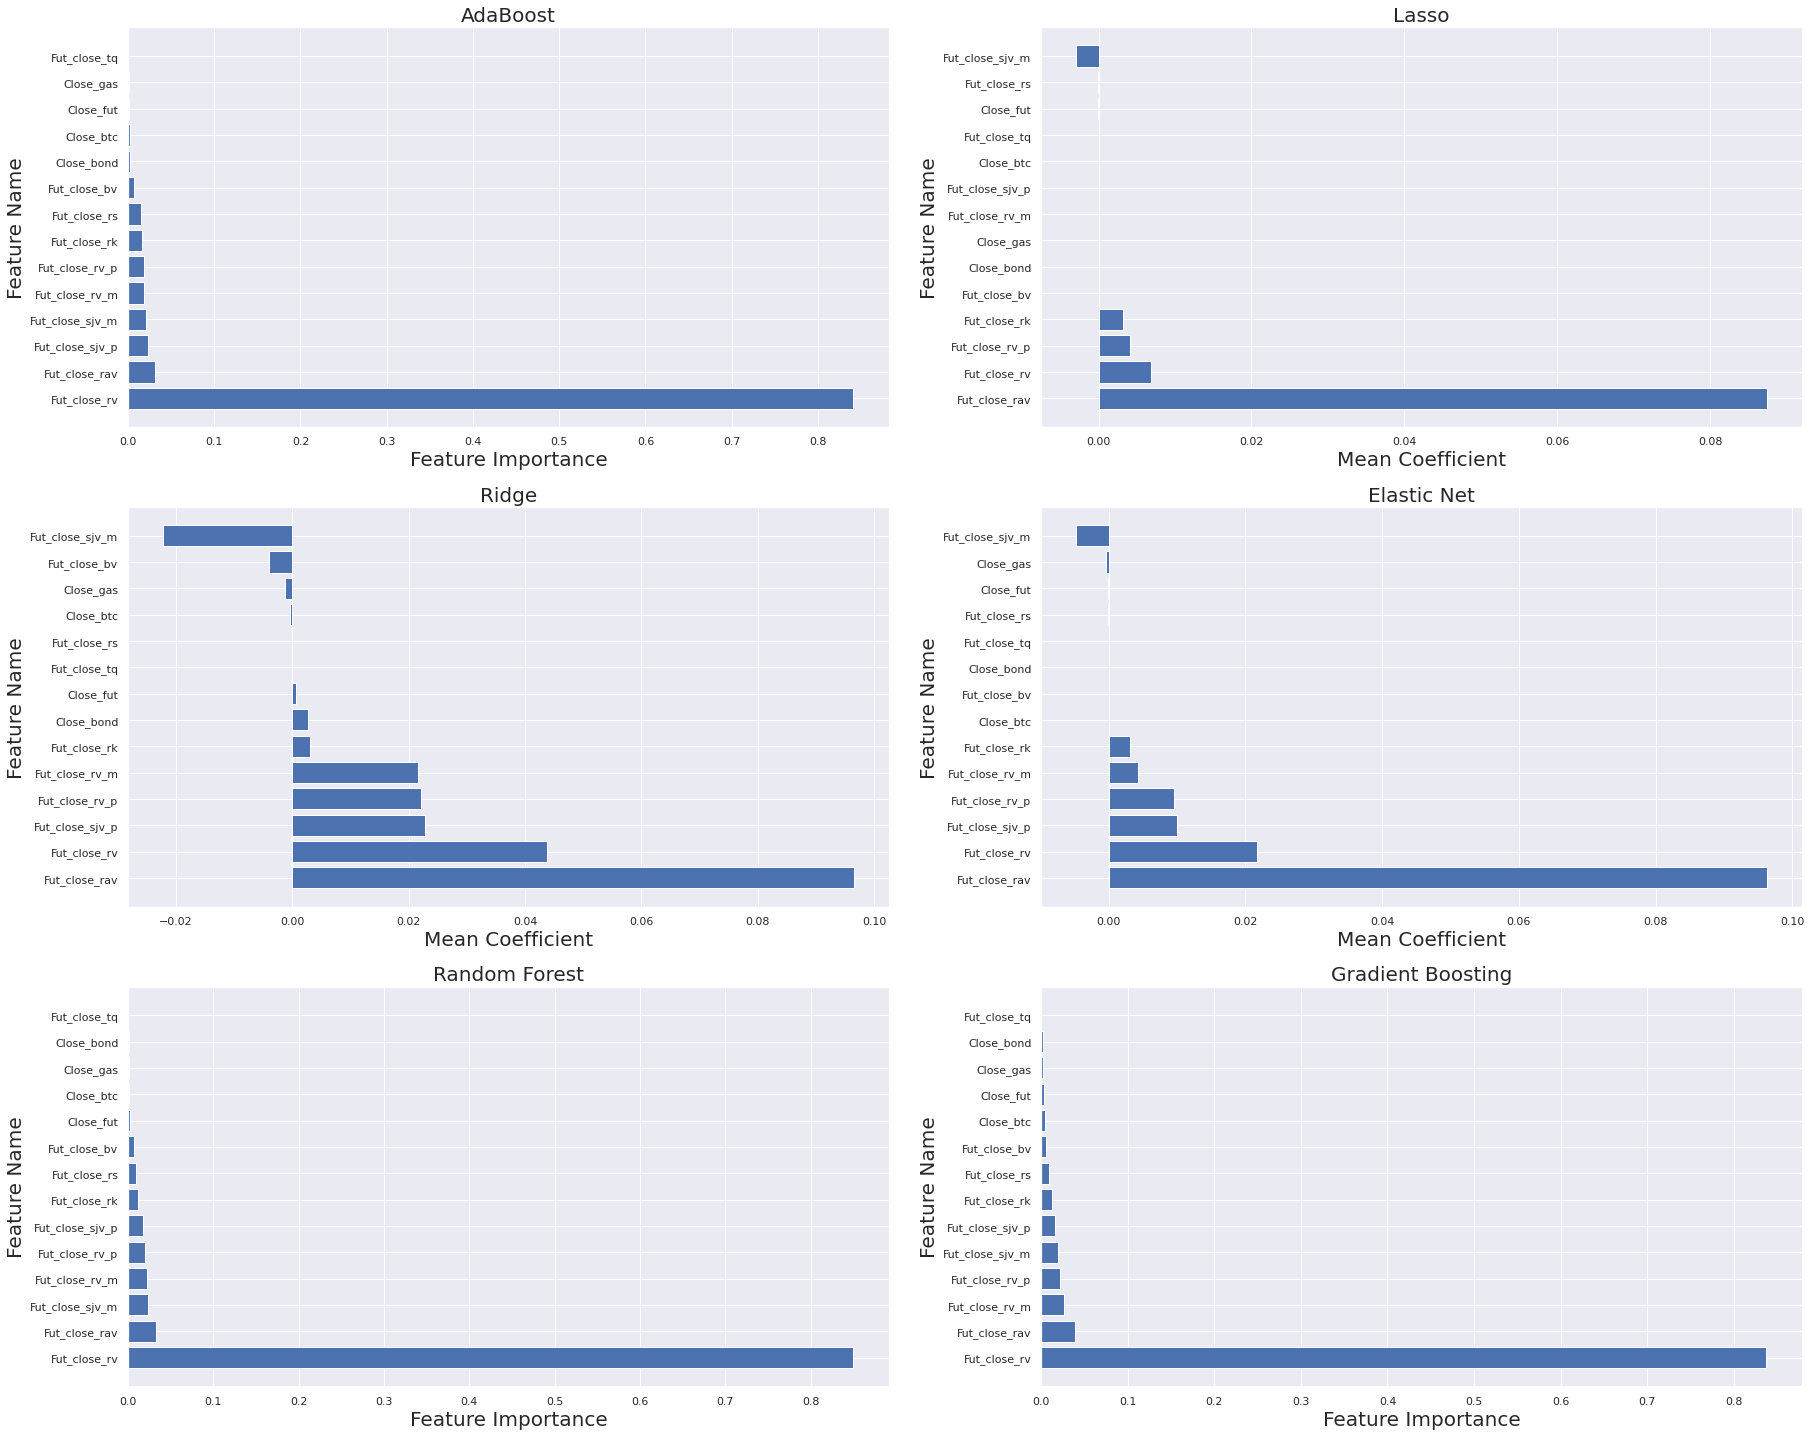

In [507]:
fig,ax = plt.subplots(3,2, figsize=(30,25))

k=0
for i in range(3):
    for j in range(2):
        m = fi_mods[k]
        # plt.axes(ax[i][j])
        ax[i][j].set_title(name_map[m], fontsize=20)
        ax[i][j].set_ylabel('Feature Name', fontsize=20)
        ax[i][j].set_xlabel('Feature Importance', fontsize=20)
        if (m=='RF'):
            plot_fi(many_ensemble_fi(fi_dict['RF'],X_train), ax[i][j])
        elif (m == 'GB') or (m == 'AB'):
            plot_fi(many_gb_fi(fi_dict[m],X_train), ax[i][j])
        elif (m == 'R') or (m == 'LA') or (m == 'EN'):
            plot_fi(many_linear_fi(fi_dict[m],X_train), ax[i][j])
            ax[i][j].set_xlabel('Mean Coefficient', fontsize=20)
        
        k+=1
plt.savefig('feat_imp.png')

In [534]:
df.corr()

,Close_fut,Close_gas,Close_btc,Close_bond,12_oil_std,Fut_close_rv,Fut_close_rav,Fut_close_bv,Fut_close_tq,Fut_close_jump_test,Fut_close_rv_m,Fut_close_rv_p,Fut_close_sjv_p,Fut_close_sjv_m,Fut_close_rs,Fut_close_rk
Close_fut,1.000000,0.106296,0.123685,-0.143304,-0.023724,0.021084,0.014643,0.111210,0.111583,-0.028135,-0.057840,0.153223,0.099861,0.183715,0.161040,-0.005454
Close_gas,0.106296,1.000000,0.059274,-0.035915,0.000776,-0.002852,-0.000330,-0.002882,-0.001872,-0.026197,-0.004707,0.000865,0.009143,0.004213,0.029669,0.015411
Close_btc,0.123685,0.059274,1.000000,-0.071214,-0.010462,-0.005936,-0.004143,0.002291,0.001701,-0.021023,-0.011055,0.003967,0.004120,0.018767,0.042610,0.001366
Close_bond,-0.143304,-0.035915,-0.071214,1.000000,0.021569,0.015148,0.009424,-0.001608,-0.001185,0.013096,0.024794,-0.004233,-0.006403,-0.039113,-0.043156,0.003737
12_oil_std,-0.023724,0.000776,-0.010462,0.021569,1.000000,0.748941,0.928185,0.596931,0.510300,0.013988,0.724373,0.654717,0.367344,-0.679001,-0.022689,0.279652
Fut_close_rv,0.021084,-0.002852,-0.005936,0.015148,0.748941,1.000000,0.711486,0.927591,0.874798,0.001407,0.962145,0.882894,0.205099,-0.773536,-0.020548,0.075247
Fut_close_rav,0.014643,-0.000330,-0.004143,0.009424,0.928185,0.711486,1.000000,0.626256,0.522963,0.003772,0.659051,0.672105,0.347983,-0.555482,-0.019540,0.136189
Fut_close_bv,0.111210,-0.002882,0.002291,-0.001608,0.596931,0.927591,0.626256,1.000000,0.965960,-0.000394,0.842626,0.904858,0.088625,-0.522892,-0.008010,0.016180
Fut_close_tq,0.111583,-0.001872,0.001701,-0.001185,0.510300,0.874798,0.522963,0.965960,1.000000,-0.000134,0.797047,0.849262,0.031411,-0.478920,-0.007132,0.010209
Fut_close_jump_test,-0.028135,-0.026197,-0.021023,0.013096,0.013988,0.001407,0.003772,-0.000394,-0.000134,1.000000,0.001988,0.000151,0.000906,-0.003285,-0.010638,0.038370
